### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [19]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText

In [20]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [21]:
test = read_data("data/split_raw/test.tsv")
print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

                                                   text  label
0     Building a wall on the U.S.-Mexico border will...      0
1     Wisconsin is on pace to double the number of l...      1
2     Says John McCain has done nothing to help the ...      1
4     When asked by a reporter whether hes at the ce...      1
5     Over the past five years the federal governmen...      0
...                                                 ...    ...
1256  Says Chris Christies plan to kick-start our ec...      1
1257  Obama used $20 million in federal money to emm...      1
1260  I think its seven or eight of the California s...      1
1261  Sen. Bob Menendez voted to enact a new tax on ...      1
1266  Says the governor is going around the state ta...      1

[790 rows x 2 columns]


Map: 100%|██████████| 790/790 [00:00<00:00, 4277.29 examples/s]


In [22]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [23]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [24]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [25]:
obs = test["text"].tolist()[0]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Building a wall on the U.S.-Mexico border will take literally years.
tensor([[    0, 37500,    10,  2204,    15,     5,   121,     4,   104,  3358,
         15780,  1424,    40,   185,  5909,   107,     4,     2]])


In [26]:
def forward(obs):
    return model(obs).logits

In [27]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000e+00,  1.2517e-06,  3.8594e-06,  2.4736e-06,  6.5118e-06,
           1.7881e-06,  4.5747e-06,  3.7402e-06,  8.7619e-06,  4.3064e-06,
           1.2890e-05,  4.6194e-06,  4.6492e-06,  1.9222e-06,  4.7684e-07,
           5.4240e-06,  4.8280e-06,  6.5118e-06],
         [ 0.0000e+00,  5.9605e-08,  1.9260e-06,  1.1623e-06,  2.6114e-06,
           9.5740e-07,  2.2333e-06,  1.8384e-06,  4.2710e-06,  2.2557e-06,
           5.8804e-06,  1.8310e-06,  1.8794e-06,  7.7300e-07, -1.0617e-07,
           2.6375e-06,  2.9430e-06,  3.6247e-06]]])

In [28]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'Building', 'Ġa', 'Ġwall', 'Ġon', 'Ġthe', 'ĠU', '.', 'S', '.-', 'Mexico', 'Ġborder', 'Ġwill', 'Ġtake', 'Ġliterally', 'Ġyears', '.', '</s>']


In [29]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
U.S.-Mexico (ORG) - Companies, agencies, institutions, etc.
literally years (DATE) - Absolute or relative dates or periods


In [30]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Building, Not part of any entity.
Token: a, Not part of any entity.
Token: wall, Not part of any entity.
Token: on, Not part of any entity.
Token: the, Not part of any entity.
Token: U.S.-Mexico, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: border, Not part of any entity.
Token: will, Not part of any entity.
Token: take, Not part of any entity.
Token: literally, Entity Type: DATE (Absolute or relative dates or periods)
Token: years, Entity Type: DATE (Absolute or relative dates or periods)
Token: ., Not part of any entity.


In [31]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

18
['Building', 'a', 'wall', 'on', 'the', 'U', '.', 'S', '.-', 'Mexico', 'border', 'will', 'take', 'literally', 'years', '.']
tensor([[[ 0.0000e+00,  1.2517e-06,  3.8594e-06,  2.4736e-06,  6.5118e-06,
           1.7881e-06,  4.5747e-06,  3.7402e-06,  8.7619e-06,  4.3064e-06,
           1.2890e-05,  4.6194e-06,  4.6492e-06,  1.9222e-06,  4.7684e-07,
           5.4240e-06,  4.8280e-06,  6.5118e-06],
         [ 0.0000e+00,  5.9605e-08,  1.9260e-06,  1.1623e-06,  2.6114e-06,
           9.5740e-07,  2.2333e-06,  1.8384e-06,  4.2710e-06,  2.2557e-06,
           5.8804e-06,  1.8310e-06,  1.8794e-06,  7.7300e-07, -1.0617e-07,
           2.6375e-06,  2.9430e-06,  3.6247e-06]]])
1


In [32]:
from engine.tokens_aggregate import TokenAggregate

In [33]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp,tokens_clear,tokens)

In [34]:
i = 0
for aggregate in aggregate_list:
    print(f"Agregate nr: {i}")
    print(f"Is spacy NER: {aggregate.is_spacy_NER}")
    print(f"spacy token: {aggregate.spacy_token}")
    print(f"Our model clean: {aggregate.clean_model_tokens}")
    print(f"Our model dirty: {aggregate.dirty_model_tokens}")
    print(f"model exp {aggregate.model_exp}")
    print("\n")
    i=i+1


Agregate nr: 0
Is spacy NER: 
spacy token: Building
Our model clean: ['Building']
Our model dirty: ['Building']
model exp [1.2516975402832031e-06]


Agregate nr: 1
Is spacy NER: 
spacy token: a
Our model clean: ['a']
Our model dirty: ['Ġa']
model exp [3.859400749206543e-06]


Agregate nr: 2
Is spacy NER: 
spacy token: wall
Our model clean: ['wall']
Our model dirty: ['Ġwall']
model exp [2.473592758178711e-06]


Agregate nr: 3
Is spacy NER: 
spacy token: on
Our model clean: ['on']
Our model dirty: ['Ġon']
model exp [6.511807441711426e-06]


Agregate nr: 4
Is spacy NER: 
spacy token: the
Our model clean: ['the']
Our model dirty: ['Ġthe']
model exp [1.7881393432617188e-06]


Agregate nr: 5
Is spacy NER: ORG
spacy token: U.S.-Mexico
Our model clean: ['U', '.', 'S', '.-', 'Mexico']
Our model dirty: ['ĠU', '.', 'S', '.-', 'Mexico']
model exp [4.5746564865112305e-06, 3.7401914596557617e-06, 8.761882781982422e-06, 4.306435585021973e-06, 1.2889504432678223e-05]


Agregate nr: 6
Is spacy NER: 
sp

In [ ]:
from tqdm import tqdm
NER = spacy.load("en_core_web_sm")
all_aggregate = []
for i,obs in tqdm(enumerate(test["text"].tolist())):
    if(device == "cuda"):
        obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
    else:
        obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()
    attr = FeatureAblationText(forward)

    exp = attr.get_attributions([obs_pt])
    tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])


    doc = NER(obs)
    tokens_clear = [s.replace("Ġ", "") for s in tokens]
    tokens_clear = tokens_clear[1:len(tokens_clear)-1]
    spacy_token_to_our_tokens = TokenAggregate.generate_aggregate_list(doc,exp,tokens_clear,tokens)
    all_aggregate = all_aggregate+spacy_token_to_our_tokens


4it [00:02,  1.23it/s]


 INVALID DOC!!! stopped at he

hesatthecenterofacriminalschemetoviolatecampaignlaws,Gov.ScottWalkernoddedyes.
spacy tokens left: ['he', 's', 'at', 'the', 'center', 'of', 'a', 'criminal', 'scheme', 'to', 'violate', 'campaign', 'laws', ',', 'Gov.', 'Scott', 'Walker', 'nodded', 'yes', '.']
model tokens left: ['hes', 'at', 'the', 'center', 'of', 'a', 'criminal', 'scheme', 'to', 'violate', 'campaign', 'laws', ',', 'Gov', '.', 'Scott', 'Walker', 'nodded', 'yes', '.']
Token: When False
Token: asked False
Token: by False
Token: a False
Token: reporter False
Token: whether False
Token: he False
Token: s False
Token: at False
Token: the False
Token: center False
Token: of False
Token: a False
Token: criminal False
Token: scheme False
Token: to False
Token: violate False
Token: campaign False
Token: laws False
Token: , False
Token: Gov. False
Token: Scott True
Token: Walker True
Token: nodded False
Token: yes False
Token: . False


12it [00:10,  1.15it/s]


 INVALID DOC!!! stopped at do

don'thavehealthcare.
spacy tokens left: ['do', "n't", 'have', 'health', 'care', '.']
model tokens left: ['don', "'t", 'have', 'health', 'care', '.']
Token: Each True
Token: year True
Token: , False
Token: 18,000 True
Token: people False
Token: die False
Token: in False
Token: America True
Token: because False
Token: they False
Token: do False
Token: n't False
Token: have False
Token: health False
Token: care False
Token: . False


30it [00:33,  1.13s/it]


<Axes: >

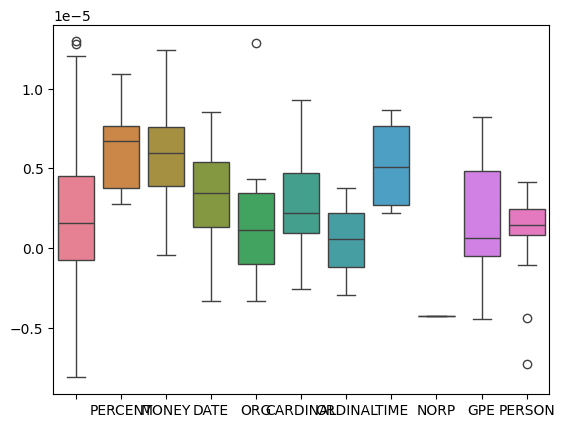

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



all_ner_types = set()

for aggregate in all_aggregate:
    all_ner_types.add(aggregate.is_spacy_NER)

exps = {}

for ner_type in all_ner_types:
    exps[ner_type] = []

for aggregate in all_aggregate:
    value = np.max(aggregate.model_exp)
    exps[aggregate.is_spacy_NER].append(value)


sns.boxplot(exps)

